In [ ]:
#| hide
from nbdev import *

# Parallel width estimator

> This implements parallel version of width-estimation routine. It runs all the calculations using a pool of nwork workers. It is using the support routines in hecss.parallel for actual execution. This should be transparent, regarding the calculator as long as these support routines support the given calculator.

In [ ]:
#| hide
from fastcore.basics import patch

In [ ]:
#| hide

import ase
from ase.calculators.vasp import Vasp
from ase.calculators import calculator
from ase.calculators.vasp.vasp import check_atoms
from ase import units as un
from tqdm.auto import tqdm
from scipy import stats
import numpy as np

In [ ]:
#| hide

from hecss import *
import hecss

In [ ]:
#|hide 
from hecss import HECSS

In [ ]:
#| hide

from hecss.util import write_dfset, calc_init_xscale
from hecss.optimize import make_sampling

In [ ]:
#| hide
from glob import glob
from tempfile import TemporaryDirectory
import os
import subprocess
from collections import defaultdict
from matplotlib import pyplot as plt


In [ ]:
#| hide
#| exporti core
import asyncio
from concurrent.futures import ThreadPoolExecutor
from hecss.parallel import __run_async
from hecss.parallel import __calculate_aio

In [ ]:
#|exporti core

@patch 
async def __estimate_width_scale_aio(self: HECSS, n=1, Tmin=0, Tmax=600, 
                                     set_scale=True, pbar=None, nwork=5):
    '''
    Async/parallel version of w-estimator. Only supported for VASP.
    Estimate coefficient between temperature and displacement scale (eta).
    Calculate energy increase from the `n` temperatures uniformly 
    distributed between 0 and `Tmax` and calculate avarage $\sqrt{E-E0/T}$
    which is a width scale for a given temperature:
    $$
        w = \\eta\\sqrt{T}
    $$
    which comes from the assumed approximate relationship:
    $$
        \\frac{E(w(T))-E_0}{T} \\approx \\mathrm{const} = \\eta^2.
    $$
    
    #### Input
    * `n`    - number of sampling points
    * `Tmax` - max sampled temperature
    * `set_scale` - set scale parameter in the class after run
    * `pbar` - show progress bar during calculation
    * `nwork` -
    
    #### Output
    * if wm_out :  mean(eta), std(eta), wm
    * else : mean(eta), std(eta)
    * wm - the nx3 array of: [width, Temperature, (E-E0)/nat]
    '''
    results = []
    
    async def worker(q, i):
        while not q.empty():
            (T, w, dx, clc) = await q.get()
            try:
                # print(f'Worker {i} run task')
                returned = await clc.__calculate_aio(clc.atoms)
                # print(f'Worker {i} done task')
                results.append((T, w, dx, clc))
                if pbar:
                    pbar.update()
            except Exception as e:
                print(f"Error executing task: {e}")

    
    # print('Parallel estimate_width_scale')
    nat = len(self.cryst)
    dim = (nat, 3)    
    
    # try:
    #     [task_queue.put_nowait(asyncio.create_task(fetch_data(root_path=row['1']))) 
    #      for index, row in run_column.iterrows()]
    #     await asyncio.gather(*[worker(task_queue) for _ in range(5)]) 
    # except Exception as e:
    #     print(f"\nUnable to get data: {e}\n")
 
    
    if pbar:
       pbar.set_description('Create') 

    # Build the queue
    structs = asyncio.Queue()    
    while structs.qsize() < n - len(self._eta_list):
        cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                       cell=self.cryst.get_cell(),
                       scaled_positions=self.cryst.get_scaled_positions(),
                       pbc=True, 
                      )
        
        T = stats.uniform.rvs(0, Tmax) # Kelvin
        if not T:
            continue
        w = self.w_scale * np.sqrt(T)
        dx = self.Q.rvs(size=dim, scale=w)

        clc = self.calc.__class__()
        clc.fromdict(self.calc.asdict())
        clc.atoms.set_positions(self.cryst.get_positions()+dx)
        try :
            clc.set(directory=f'{self.directory}/w_est/{len(self._eta_list)+structs.qsize():03d}')
        except AttributeError :
            # Calculator is not directory-based
            # Ignore the error
            pass
        clc.set(command=self.calc.command)
        structs.put_nowait((T, w, dx, clc))
        if pbar:
            pbar.update()
            
    if pbar:
        pbar.reset(structs.qsize())
        pbar.set_description('Collect') 

    if nwork is None or nwork < 1:
        nwork = structs.qsize()
    await asyncio.gather(*[worker(structs, _) for _ in range(nwork)]) 

    while results:
        T, w, dx, clc = results.pop()
        E = clc.get_potential_energy()
        i = len(self._eta_list)
        self._eta_samples.append((i, i, dx, clc.get_forces(), (E-self.Ep0)/nat))
        self._eta_list.append([w, T, (E-self.Ep0)/nat])

    return

In [ ]:
#|exporti core

@patch 
def _estimate_width_scale_aio(self: HECSS, n=1, Tmin=0, Tmax=600, 
                              set_scale=True, pbar=None, nwork=5):
    '''
    Runner for the asynchronous version of width estimator.
    Guards against not supported calculators and serial call
    request (nwork==None) with NotImplementedError exception.
    '''
    if nwork is None:
        # Silent. This is parallel version. Use serial instead.
        raise NotImplementedError
    if self.calc.name in ('vasp',):
        __run_async(self.__estimate_width_scale_aio, n, Tmin, Tmax, set_scale, pbar, nwork)
    else :
        # Warn if the call was for parallel version with unsupported
        # calculator. Silent, if the call was for serial version. 
        print('WARNING: Parallel execution supported only for some calculators.')
        print('Using serial version')
        raise NotImplementedError

In [ ]:
#| vasp
# Quick test using conventional unit cell
supercell = '1x1x1'

In [ ]:
#| vasp
#| slow
# Slow more realistic test
supercell = '2x2x2'

In [ ]:
#|hide
#|eval: false
# Reset supercell for interactive work (not executed in tests)
supercell = '1x1x1'

In [ ]:
#|vasp
# Directory in which our project resides
base_dir = f'example/VASP_3C-SiC_calculated/{supercell}/'
calc_dir = TemporaryDirectory(dir='TMP')

In [ ]:
#| vasp
# Read the structure (previously calculated unit(super) cell)
# The command argument is specific to the cluster setup
calc = Vasp(label='cryst', directory=f'{base_dir}/sc/', restart=True)

# This just makes a copy of atoms object
# Do not generate supercell here - your atom ordering will be wrong!
cryst = calc.atoms.repeat(1)

In [ ]:
#|vasp
print('Stress tensor: ', end='')
for ss in calc.get_stress()/un.GPa:
    print(f'{ss:.3f}', end=' ')
print('GPa')
Ep0 = calc.get_potential_energy()

Stress tensor: 0.017 0.017 0.017 0.000 0.000 0.000 GPa


In [ ]:
#|vasp
# Setup the calculator - single point energy calculation
# The details will change here from case to case
# We are using run-vasp from the current directory!
calc.set(directory=f'{calc_dir.name}/sc')
calc.set(command=f'{os.getcwd()}/run-calc.sh "async"')
calc.set(nsw=0)
cryst.calc = calc

In [ ]:
#|vasp
# Prepare space for the results.
# We use defaultdict to automatically
# initialize the items to empty list.
samples = defaultdict(lambda : [])

# Space for amplitude correction data
xsl = []

In [ ]:
#|vasp
# Build the sampler
hecss = HECSS(cryst, calc, 
              directory=calc_dir.name,
              w_search = True,
              pbar=True,
              )

In [ ]:
#|vasp
hecss.Ep0 = Ep0

## Triggering parallel calculations

The parallel version of the `estimate_width_scale` method is triggered by setting `nwork` parameter to number of parallel workers which should be used. If `nwork=0` the number of workers will be equal to number of required samples `N`.

In [ ]:
#|vasp
N = 10
m, s, xscl = hecss.estimate_width_scale(1, Tmax=2000)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#|vasp
await hecss.__estimate_width_scale_aio(N//2, Tmax=2000, nwork=N//2)

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(N, Tmax=2000, nwork=N//2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(N//2, Tmax=2000, nwork=3)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(2*N, Tmax=2000, nwork=N)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
#|vasp
m, s, xscl = hecss.estimate_width_scale(3*N, Tmax=2000, nwork=0)

  0%|          | 0/30 [00:00<?, ?it/s]

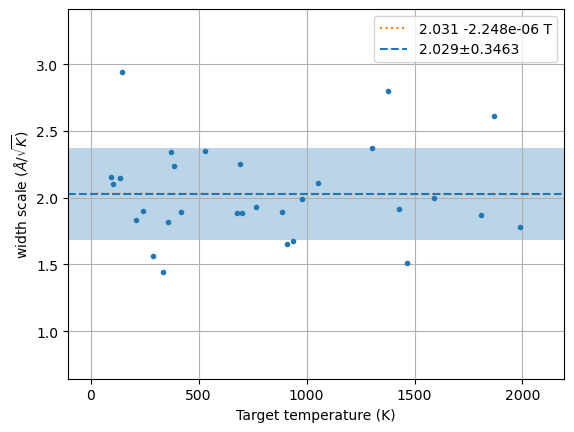

In [ ]:
#|vasp
# plt.semilogy()
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(wm[1], y, '.');
x = np.linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.4g} {fit[0]:+.4g} T')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
# plt.ylim(0, m+4*s)
plt.xlabel('Target temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.grid()
plt.legend();

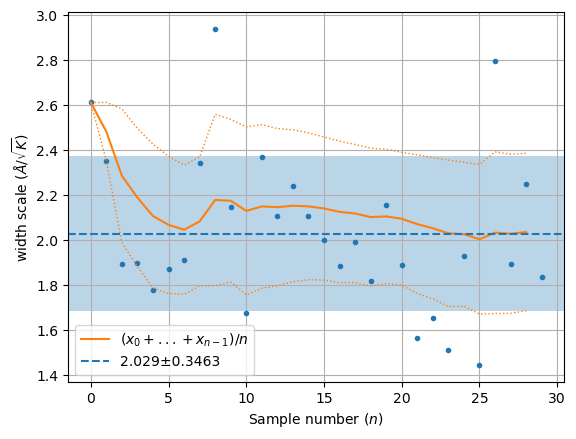

In [ ]:
#|vasp
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(y, '.')
rm = np.array([y[:l].mean() for l in range(1, len(y))])
rv = np.array([y[:l].std() for l in range(1, len(y))])
plt.plot(rm, '-', label='$ (x_0 + ... + x_{n-1})/n$')
plt.plot(rm + rv, ':', lw=1, color='C1')
plt.plot(rm - rv, ':', lw=1, color='C1')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.xlabel('Sample number ($n$)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.grid()
plt.legend();


## Directory clean-up routine

> This is executed by default to clean-up after the tests. If you want to clean up the directory after running the notebook change CLEANUP to True. The directory is always cleaned after successful tests run in command line mode. The default False value skips the cleanup for manual runs to leave calculation directory for inspection.

In [ ]:
#|hide
#|vasp
#|eval: false
CLEANUP=False

In [ ]:
#|hide
#|vasp
try :
    if CLEANUP:
       calc_dir.cleanup() 
except NameError:
    calc_dir.cleanup()